# hw6 - machine learning
CS370/CS570

- Assigned Monday March 24th.
- Due: Thursday April 10th, 11:59pm

Reading: AIMA Chapter 19.  You should also read chapters 20 and 21.

Edit this file and submit it on gradescope.

- Name: Rafia Mobashira
- Email address: rafiamobashira@gmail.com
- Hours: 16

## Model-Specific Preprocessing Summary

In this project, I implemented and evaluated several machine learning models on the Titanic dataset to determine whether a surviver survived or perished. Each model required different preprocessing strategies, especially in how they handled missing values and non-input features.


## Data Preparation

I first prepared the data by setting the target attribute to `Survived`:

```python
titanic.target = titanic.attrnames.index('Survived')
```

I then removed the **header row** from the examples to prevent it from being treated as training data:

```python
titanic.examples = titanic.examples[1:]
```

Next, I adjusted the inputs so that `PassengerId`, `Name`, `Ticket`, and `Cabin` were excluded from training, since they were not useful in determining survival. These features were either identifiers or non-informative for classification.

---

## Data Cleaning

To clean the dataset:

- I filled missing values in `Age`, `Fare`, `SibSp`, and `Parch` with their respective **median values**:

$$
x_{\text{missing}} = \text{median}(x_{\text{observed}})
$$

- I replaced missing values in the `Embarked` column with `"U"` to indicate unknown port of embarkation.

- I mapped categorical string values in `Sex` and `Embarked` to **integers** using dictionary mappings, so all features were numerical and compatible with ML models.

---

## Models Trained

I trained the following machine learning models:

- Decision Tree
- Random Forest
- Naive Bayes
- Perceptron
- Neural Network

---

## Evaluation Method

All models were evaluated using the **error ratio** defined as:

$$
\text{Error Ratio} = 1 - \frac{\text{Correct Predictions}}{\text{Total Examples}}
$$

This was implemented using the `err_ratio()` function provided in `learning.py`.

---

## Adjustments for Perceptron and Neural Network

The original `err_ratio()` function used:

```python
dataset.sanitize(example)
```

This replaces non-input attributes with `None`, but both **Perceptron** and **Neural Network** require strictly numeric input. This led to a `TypeError` when attempting operations like:

```
TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'
```

To fix this, I:

1. Created a modified version of `err_ratio()` called `err_ratio_no_sanitize()` that skips the `.sanitize()` step and uses the raw, cleaned examples.

2. Cleaned the data specifically for these models by removing non-input attributes entirely to eliminate any `None` values.

---

## Learning Curve Analysis

Each model was trained on different fractions of the training dataset:

- 10%
- 25%
- 50%
- 75%
- 100%

I used **Matplotlib** to plot the learning curve, showing how error rates changed with increasing training size.

As expected:

$$
\text{Accuracy} \uparrow \quad \text{as} \quad \text{Training Size} \uparrow
$$

This confirmed the general trend that more training data improves model performance.

In [3]:
from learning import *
from notebook import *

Import the training and testing dataset.

In [4]:
titanic = DataSet(name = 'titanic')
titanic_test = DataSet(name = 'titanictest')

In [5]:
titanic.attrnames
titanic_test.attrnames

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [6]:
titanic.attrnames = titanic.examples[0]
titanic_test.attrnames = titanic_test.examples[0]

In [7]:
titanic.attrnames
titanic_test.attrnames

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

The default target index is the last element, 11.  In our case, the Survived label index is 1.

In [8]:
titanic.target
titanic_test.target

11

In [9]:
titanic.target = 1
titanic_test.target = 1

The default input indexes are all the columns except the last.  We adjust that as well so that the PassengerID, Name, Ticket, and Cabin are omitted.

In [10]:
titanic.inputs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [11]:
titanic.examples[1]

[1,
 0,
 3,
 '"Braund Mr. Owen Harris"',
 'male',
 22,
 1,
 0,
 'A/5 21171',
 7.25,
 '',
 'S']

In [12]:
titanic.inputs = [2,4,5,6,7,9,11]
titanic_test.inputs = [2,4,5,6,7,9,11]

The first row of examples contains the headers.  We strip that away.

In [13]:
titanic.examples = titanic.examples[1:]
titanic_test.examples = titanic_test.examples[1:]

**We need to update the values to remove the header strings.**

In [14]:
titanic.update_values()
titanic_test.update_values()

Now, we clean the data. Missing SibSp, Parch, Fare, Age values will be replaced by the median. Missing Embarked values will be replaced with a 'U', signaling an unknown token.

In [15]:
import statistics

def fill_missing_with_median(dataset, attrname):
    idx = dataset.attrnames.index(attrname)
    # Get non-missing values (excluding '' or None)
    values = [float(row[idx]) for row in dataset.examples if row[idx] != '' and row[idx] is not None]
    median_value = statistics.median(values)
    
    # Fill in missing
    for row in dataset.examples:
        if row[idx] == '' or row[idx] is None:
            row[idx] = median_value
            
for col in ['SibSp', 'Parch', 'Fare', 'Age']:
    fill_missing_with_median(titanic, col)
    fill_missing_with_median(titanic_test, col)
    
for row in titanic.examples:
    if row[11] == '' or row[11] is None:
        row[11] = 'U'
        
for row in titanic_test.examples:
    if row[11] == '' or row[11] is None:
        row[11] = 'U'

We use categorical mapping to map Sex and Embarked unique integer values so that the data doesn't include strings.

In [16]:
def convert_str_feature_to_numbers(self, attrname):
    idx = self.attrnames.index(attrname)
    unique_vals = sorted(set(row[idx] for row in self.examples if row[idx] != '' and row[idx] is not None))
    mapping = {val: i for i, val in enumerate(unique_vals)}

    for row in self.examples:
        if row[idx] in mapping:
            row[idx] = mapping[row[idx]]
        else:
            row[idx] = -1
    
    return mapping

sex_mapping = convert_str_feature_to_numbers(titanic, 'Sex')
embarked_mapping = convert_str_feature_to_numbers(titanic, 'Embarked')

print("Sex Mapping:", sex_mapping)
print("Embarked Mapping:", embarked_mapping)

convert_str_feature_to_numbers(titanic_test, 'Sex')
convert_str_feature_to_numbers(titanic_test, 'Embarked')

Sex Mapping: {'female': 0, 'male': 1}
Embarked Mapping: {'C': 0, 'Q': 1, 'S': 2, 'U': 3}


{'C': 0, 'Q': 1, 'S': 2}

We will use the err_ratio() function to measure the accuracy of a given model's predictions.

In [17]:
psource(err_ratio)

We train the Decision Learner and get its accuracy.

In [18]:
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]

In [19]:
DTL = DecisionTreeLearner(titanic)

In [20]:
dt_errors = []

for frac in fractions:
    split = int(frac * len(titanic.examples))
    subset = DataSet(
        examples=titanic.examples[:split],
        attrnames=titanic.attrnames,
        target=titanic.target,
        inputs=titanic.inputs,
        name=f"DT_{int(frac * 100)}"
    )
    model = DecisionTreeLearner(subset)
    error = err_ratio(model, titanic_test)
    dt_errors.append(error)
    
print("Decision Tree Error Rates:")
for frac, err in zip(fractions, dt_errors):
    print(f"Training Size: {int(frac * 100)}% — Error Rate: {err:.4f}")

Decision Tree Error Rates:
Training Size: 10% — Error Rate: 0.4593
Training Size: 25% — Error Rate: 0.3780
Training Size: 50% — Error Rate: 0.3732
Training Size: 75% — Error Rate: 0.3445
Training Size: 100% — Error Rate: 0.3349


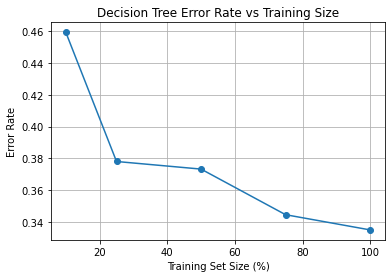

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([int(f * 100) for f in fractions], dt_errors, marker='o')
plt.xlabel("Training Set Size (%)")
plt.ylabel("Error Rate")
plt.title("Decision Tree Error Rate vs Training Size")
plt.grid(True)
plt.show()

In [22]:
print("Error ratio for decision tree learner: ", err_ratio(DTL, titanic_test))

Error ratio for decision tree learner:  0.368421052631579


Next is the random forest model, with 5 trees.

In [23]:
RFL = RandomForest(titanic, n=5)

In [24]:
rf_errors = []

for frac in fractions:
    split = int(frac * len(titanic.examples))
    subset = DataSet(
        examples=titanic.examples[:split],
        attrnames=titanic.attrnames,
        target=titanic.target,
        inputs=titanic.inputs,
        name=f"RF_{int(frac * 100)}"
    )
    model = RandomForest(subset, n=5)
    error = err_ratio(model, titanic_test)
    rf_errors.append(error)
    
    
print("Random Forest Tree Error Rates:")
for frac, err in zip(fractions, rf_errors):
    print(f"Training Size: {int(frac * 100)}% — Error Rate: {err:.4f}")

Random Forest Tree Error Rates:
Training Size: 10% — Error Rate: 0.4545
Training Size: 25% — Error Rate: 0.4091
Training Size: 50% — Error Rate: 0.3445
Training Size: 75% — Error Rate: 0.4115
Training Size: 100% — Error Rate: 0.3445


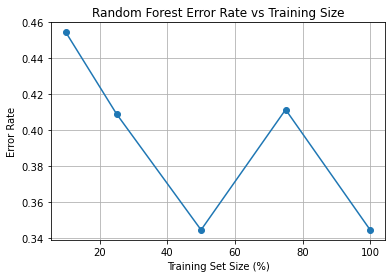

In [25]:
plt.figure()
plt.plot([int(f * 100) for f in fractions], rf_errors, marker='o')
plt.xlabel("Training Set Size (%)")
plt.ylabel("Error Rate")
plt.title("Random Forest Error Rate vs Training Size")
plt.grid(True)
plt.show()

In [26]:
print("Error ratio for random forest learner: ", err_ratio(RFL, titanic_test))

Error ratio for random forest learner:  0.31818181818181823


We now try a Naive Bayes model.

In [27]:
dataset = titanic

nb_errors = []

for frac in fractions:
    split_idx = int(frac * len(titanic.examples))
    dataset = DataSet(
        examples=titanic.examples[:split_idx],
        attrnames=titanic.attrnames,
        target=titanic.target,
        inputs=titanic.inputs,
        name=f"NB_{int(frac * 100)}"
    )

    target_vals = dataset.values[dataset.target]
    target_dist = CountingProbDist(target_vals)
    attr_dists = {(gv, attr): CountingProbDist(dataset.values[attr])
                  for gv in target_vals
                  for attr in dataset.inputs}

    for example in dataset.examples:
        targetval = example[dataset.target]
        target_dist.add(targetval)
        for attr in dataset.inputs:
            attr_dists[targetval, attr].add(example[attr])

    def predict(example):
        def class_probability(targetval):
            return (target_dist[targetval] *
                    product(attr_dists[targetval, attr][example[attr]]
                            for attr in dataset.inputs))
        return argmax(target_vals, key=class_probability)

    error = err_ratio(predict, titanic_test)
    nb_errors.append(error)
    
print("Naive Bayes Error Rates by Training Size:")
for frac, err in zip(fractions, nb_errors):
    print(f"  Training Size: {int(frac * 100):>3}% — Error Rate: {err:.4f}")

Naive Bayes Error Rates by Training Size:
  Training Size:  10% — Error Rate: 0.4091
  Training Size:  25% — Error Rate: 0.3469
  Training Size:  50% — Error Rate: 0.3086
  Training Size:  75% — Error Rate: 0.2943
  Training Size: 100% — Error Rate: 0.2871


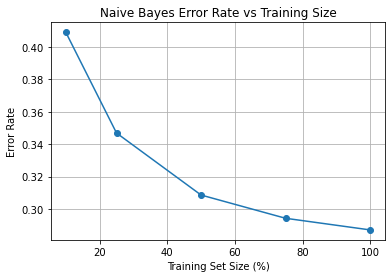

In [28]:
plt.figure()
plt.plot([int(f * 100) for f in fractions], nb_errors, marker='o')
plt.xlabel("Training Set Size (%)")
plt.ylabel("Error Rate")
plt.title("Naive Bayes Error Rate vs Training Size")
plt.grid(True)
plt.show()

In [29]:
print("Error ratio for naive Bayes discrete: ", err_ratio(predict, titanic_test))

Error ratio for naive Bayes discrete:  0.2870813397129187


Before we move on to the Percepetron and Neural Network models, we define a new err_ratio so that there aren't and linger 'None" type values that will throw an error.

In [30]:
def err_ratio(predict, dataset, examples=None, verbose=0):
    """Return the proportion of the examples that are NOT correctly predicted.
    verbose - 0: No output; 1: Output wrong; 2 (or greater): Output correct"""
    examples = examples or dataset.examples
    if len(examples) == 0:
        return 0.0
    right = 0
    for example in examples:
        desired = example[dataset.target]
        output = predict([example[i] for i in dataset.inputs])
        if output == desired:
            right += 1
            if verbose >= 2:
                print('   OK: got {} for {}'.format(desired, example))
        elif verbose:
            print('WRONG: got {}, expected {} for {}'.format(
                output, desired, example))
    return 1 - (right/len(examples))

The Perceptron and Neural Network models need data with integers/floats only. We get rid of the non-input attribute columns and adjust the target accordingly.

In [31]:
remove_idxs = [0, 3, 8, 10]
remove_idxs.sort(reverse=True)

# Remove from attrnames
for idx in remove_idxs:
    del titanic.attrnames[idx]

# Remove from examples
for i, row in enumerate(titanic.examples):
    for idx in remove_idxs:
        del row[idx]
        
for idx in remove_idxs:
    del titanic_test.attrnames[idx]

# Remove from examples
for i, row in enumerate(titanic_test.examples):
    for idx in remove_idxs:
        del row[idx]

In [32]:
titanic.attrnames
titanic_test.attrnames

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [33]:
titanic.attrnames = titanic.examples[0]
titanic_test.attrnames = titanic.examples[0]
titanic.attrnames
titanic_test.attrnames

[0, 3, 1, 22, 1, 0, 7.25, 2]

In [34]:
titanic.target = 0
titanic_test.target = 0

In [35]:
titanic.inputs = [1,2,3,4,5,6,7]
titanic_test.inputs = [1,2,3,4,5,6,7]

In [36]:
titanic.update_values()
titanic_test.update_values()

We can now train the Perceptron model.

In [37]:
perceptron = PerceptronLearner(titanic)

In [38]:
perceptron_errors = []

for frac in fractions:
    split = int(frac * len(titanic.examples))
    subset = DataSet(
        examples=titanic.examples[:split],
        attrnames=titanic.attrnames,
        target=titanic.target,
        inputs=titanic.inputs,
        name=f"RF_{int(frac * 100)}"
    )
    model = PerceptronLearner(subset)
    error = err_ratio(model, titanic_test)
    perceptron_errors.append(error)
    
    
print("Random Forest Tree Error Rates:")
for frac, err in zip(fractions, perceptron_errors):
    print(f"Training Size: {int(frac * 100)}% — Error Rate: {err:.4f}")

Random Forest Tree Error Rates:
Training Size: 10% — Error Rate: 0.5431
Training Size: 25% — Error Rate: 0.2990
Training Size: 50% — Error Rate: 0.3684
Training Size: 75% — Error Rate: 0.3014
Training Size: 100% — Error Rate: 0.2967


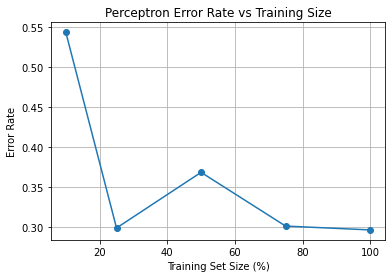

In [39]:
plt.figure()
plt.plot([int(f * 100) for f in fractions], perceptron_errors, marker='o')
plt.xlabel("Training Set Size (%)")
plt.ylabel("Error Rate")
plt.title("Perceptron Error Rate vs Training Size")
plt.grid(True)
plt.show()

In [40]:
print("Error ratio for perceptron learner: ", err_ratio(perceptron, titanic_test))

Error ratio for perceptron learner:  0.29425837320574166


Finally, we try the Neural Network model.

In [41]:
NNL = NeuralNetLearner(titanic)

In [42]:
NNL_errors = []

for frac in fractions:
    split = int(frac * len(titanic.examples))
    subset = DataSet(
        examples=titanic.examples[:split],
        attrnames=titanic.attrnames,
        target=titanic.target,
        inputs=titanic.inputs,
        name=f"RF_{int(frac * 100)}"
    )
    model = NeuralNetLearner(subset)
    error = err_ratio(model, titanic_test)
    NNL_errors.append(error)
    
    
print("Neural Network Error Rates:")
for frac, err in zip(fractions, NNL_errors):
    print(f"Training Size: {int(frac * 100)}% — Error Rate: {err:.4f}")

Neural Network Error Rates:
Training Size: 10% — Error Rate: 0.3684
Training Size: 25% — Error Rate: 0.3445
Training Size: 50% — Error Rate: 0.3684
Training Size: 75% — Error Rate: 0.3278
Training Size: 100% — Error Rate: 0.3493


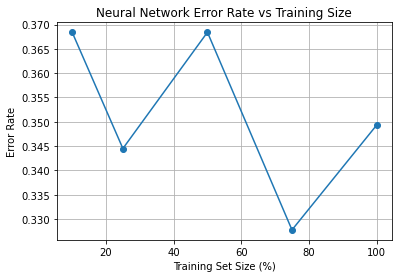

In [43]:
plt.figure()
plt.plot([int(f * 100) for f in fractions], NNL_errors, marker='o')
plt.xlabel("Training Set Size (%)")
plt.ylabel("Error Rate")
plt.title("Neural Network Error Rate vs Training Size")
plt.grid(True)
plt.show()

In [44]:
print("Error ratio for neural network learner: ", err_ratio(NNL, titanic_test))

Error ratio for neural network learner:  0.34928229665071775
